In [1]:
import torch
from torch import optim, utils

from getdist import plots, MCSamples
import matplotlib.pyplot as plt

from Network import Generator, Discriminator
from Signal_Generator import *

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = []

for i in range(16000):
    SG = Signal_Generator(num_sources=1, noise_amplitude=1)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

num_latent_variables = 20
learning_rate = 1e-5

In [ ]:
class GAN():
    def __init__(self, dataset, num_latent_variables, lr):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)
        self.criterion = nn.BCELoss()

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def adversarial_loss(self, output_d, y):
        return self.criterion(output_d, y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = self.adversarial_loss(fake_output, torch.ones_like(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        real_loss = self.adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = self.adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        return d_loss.item()

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
# Train the GAN
for i in range(200):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

In [ ]:
plt.plot(d_loss_list)
plt.yscale('log')

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

g_loss_list = []
# Train the GAN
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = gan.train_generator(signal_tensor, z)
        g_loss_list.append(g_loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

In [ ]:
plt.plot(g_loss_list)
#plt.yscale('log')

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)
g_loss_list = []
d_loss_list = []

num_epochs = 50
num_discriminator = 3
num_generator = 3

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)

        for _ in range(num_discriminator):
            g_loss = gan.train_generator(signal_tensor, z)
            g_loss_list.append(g_loss)

        for _ in range(num_generator):
            d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
            d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

In [ ]:
generator = gan.generator
generator.eval()

for i in range(10):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    print(params)
    print(generated_params)

In [3]:
class WGAN():
    def __init__(self, dataset, num_latent_variables, lr, weight_clip):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

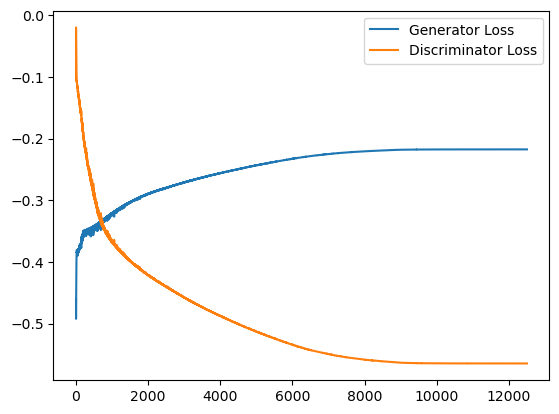

In [7]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
# Train the GAN
for i in range(100):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend()

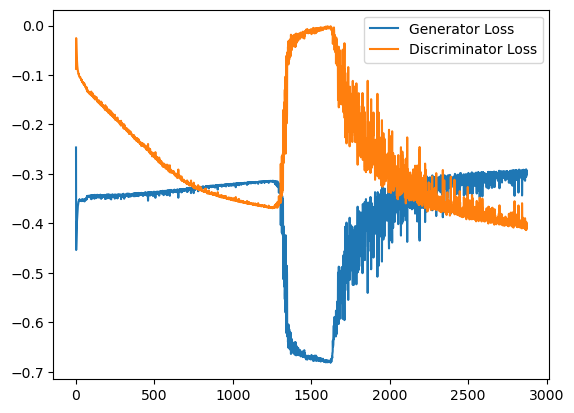

In [14]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

for i in range(3):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend()

100%|██████████| 500/500 [1:20:54<00:00,  9.71s/it]


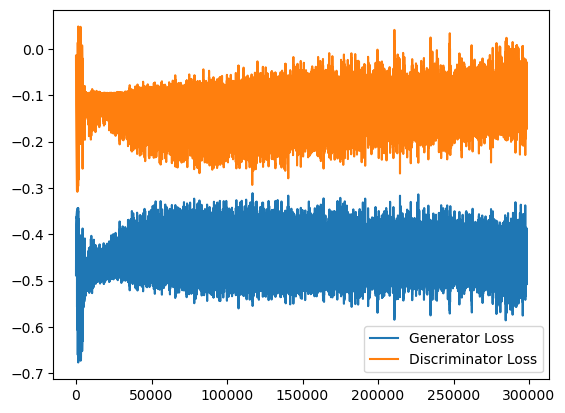

In [72]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []

ncri_list = []
ngen_list = []

d_loss_threshold = -0.1
g_loss_threshold = -0.3

loss_adjustment = 0.025
max_steps = 300

num_epochs = 500

training_d = True

for epoch in tqdm(range(num_epochs)):
    ncri = 0
    ngen = 0
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)

        critic_steps = 0
        generator_steps = 0
        
        while training_d and critic_steps < max_steps:
            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ncri+=1
            critic_steps+=1
            if loss[0] > g_loss_threshold:
                training_d = False
                break

        if critic_steps == max_steps:
            g_loss_threshold -= loss_adjustment

        while not training_d and generator_steps < max_steps:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ngen+=1
            generator_steps+=1
            if loss[1] > d_loss_threshold:
                training_d = True
                break

        if generator_steps == max_steps:
            d_loss_threshold -= loss_adjustment

    ncri_list.append(ncri)
    ngen_list.append(ngen)

    #print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {loss[0]}, Discriminator loss: {loss[1]}")

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend()

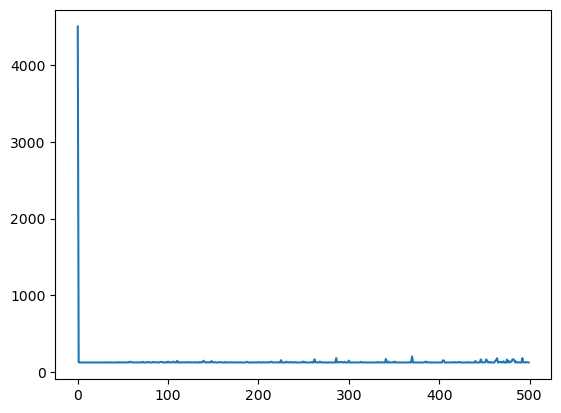

In [75]:
plt.plot(ncri_list, label='Number of critic steps')

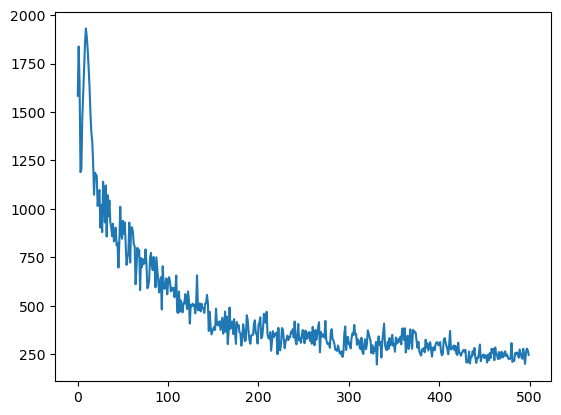

In [78]:
plt.plot(ngen_list, label='Number of generator steps')

In [79]:
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):

        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

In [92]:
generator = wgan.generator
generator.eval()

generated_params_list = []

TS = Signal_Generator(num_sources=1, noise_amplitude=1)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

for i in range(10000):
    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    generated_params_list.append(generated_params)

In [93]:
params

[8.628126641744602, 0.2751076626707549, 1.1488044660717784]

In [94]:
generated_params_list

[array([8.639516  , 0.28417847, 1.1772127 ], dtype=float32),
 array([8.482999  , 0.31178987, 1.1147825 ], dtype=float32),
 array([8.517871  , 0.23643558, 1.0634879 ], dtype=float32),
 array([8.298932  , 0.30400446, 1.0189143 ], dtype=float32),
 array([8.791879  , 0.26012725, 1.0311044 ], dtype=float32),
 array([8.442206 , 0.3416993, 0.980412 ], dtype=float32),
 array([8.105449  , 0.2833054 , 0.84876096], dtype=float32),
 array([8.746414  , 0.24980925, 1.1085548 ], dtype=float32),
 array([8.538326  , 0.28949943, 1.0387762 ], dtype=float32),
 array([8.466433  , 0.2992889 , 0.94313866], dtype=float32),
 array([8.513364  , 0.32181802, 1.1126617 ], dtype=float32),
 array([8.150057  , 0.2680328 , 0.97930235], dtype=float32),
 array([8.573846  , 0.28459492, 1.1052599 ], dtype=float32),
 array([8.807888  , 0.31600553, 0.6327128 ], dtype=float32),
 array([8.8848295 , 0.2680982 , 0.97608995], dtype=float32),
 array([8.304602  , 0.27895683, 0.969204  ], dtype=float32),
 array([8.458897  , 0.29796

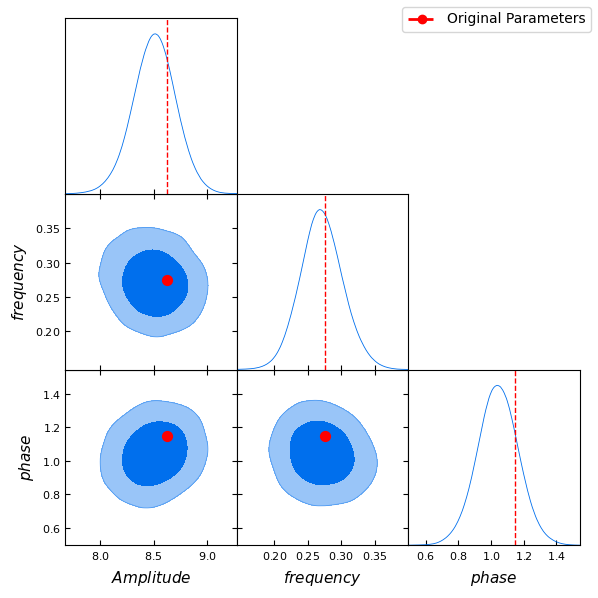

In [95]:
generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])


names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels, settings={'ignore_rows': 1000})
#samples.setRanges([[-3,3],[-3,3]])
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

g = plots.get_subplot_plotter()

g.triangle_plot([generated_params_samples], filled=True)

axes = g.subplots

for i in range(len(names)):
    for j in range(i+1, len(names)):
        ax = axes[j, i]
        if ax is not None:
            ax.scatter(params[i], params[j], color='red', marker='o', s=50)

for i in range(len(names)):
    ax = axes[i, i]
    if ax is not None:
        ax.axvline(params[i], linestyle='--', color='red', lw=1)

handles = [plt.Line2D([0], [0], color='red', lw=2, linestyle='--', marker='o')]
labels = ['Original Parameters']
g.fig.legend(handles, labels, loc='upper right')

plt.show()
#g.export('weight_clip_0.1for300epochs.png')

In [90]:
generator = wgan.generator
generator.eval()

params_list = []
generated_params_list = []

test_times = 30
for i in range(test_times):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    print(params)
    print(generated_params)

[6.3885600979463355, 0.3057208049410172, 0.09011100339898696]
[6.5451035  0.24693336 0.48610643]
[11.057997967191678, 0.2889967675249866, 1.7079451047903917]
[10.851901   0.2980916  1.6134151]
[11.267905005329904, 0.2966647837578269, 5.124361690210028]
[11.259568    0.32821825  4.914699  ]
[11.985011030918121, 0.2384547985807554, 1.1604215996225553]
[11.943532   0.2914493  0.7264039]
[10.407911312344492, 0.27419546667774125, 3.04437816149699]
[10.29266    0.2722967  2.775143 ]
[12.332792138116384, 0.3132644395703313, 3.318257709145329]
[11.738522   0.4150159  3.3357074]
[9.54752845986117, 0.3917740620204874, 2.7839491391260336]
[9.101016   0.43862614 1.9598631 ]
[10.246238140819973, 0.3471582585706219, 3.9270519047699106]
[9.718234   0.36481935 3.821768  ]
[12.205240804887293, 0.3515173988380529, 4.592717214353732]
[12.256179    0.41679093  4.808816  ]
[9.876941268569473, 0.3189269417281767, 3.8298332212697948]
[9.692037   0.40583548 3.6413577 ]
[12.420696317133256, 0.35440717113580184

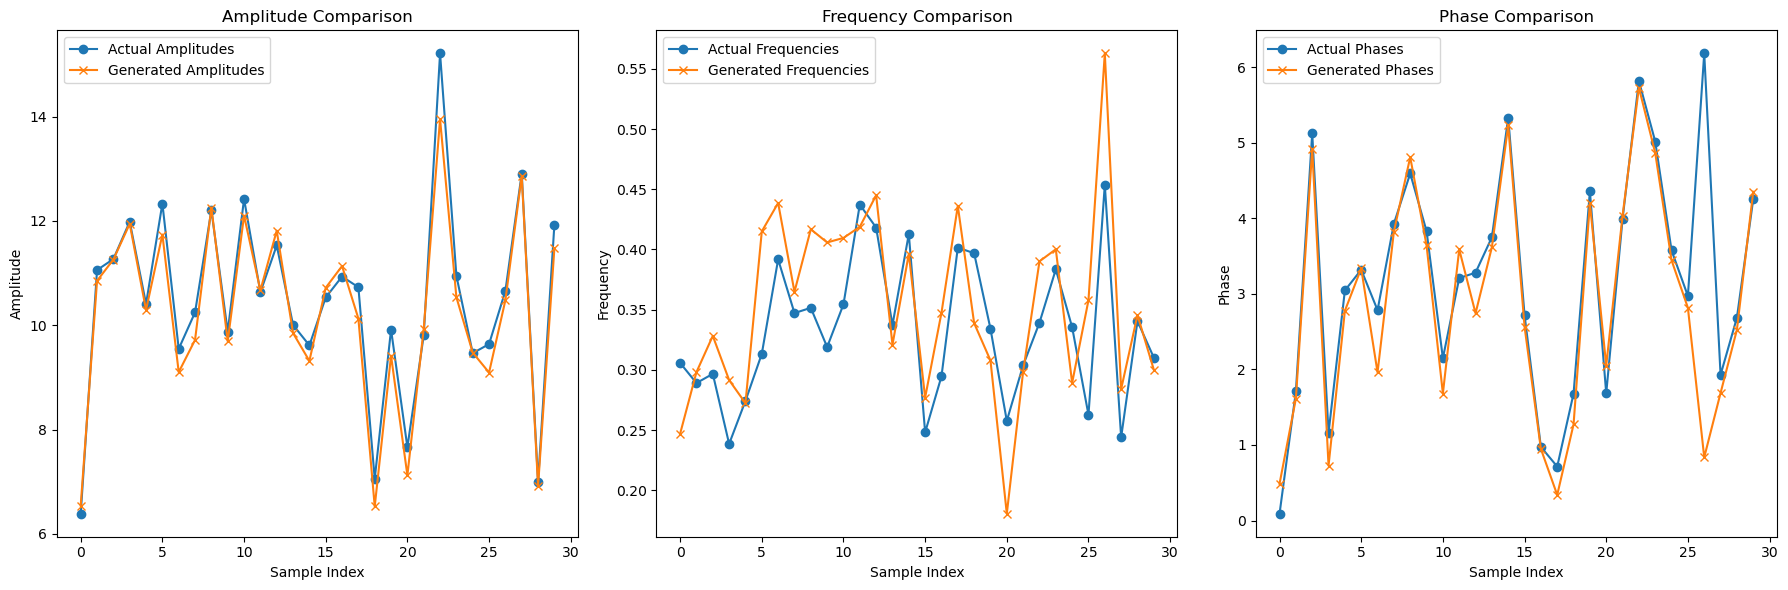

In [91]:
actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(test_times), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(test_times), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(test_times), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(test_times), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(test_times), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(test_times), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.tight_layout()
plt.show()